In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

%matplotlib inline

In [270]:
train_df = pd.read_csv('input/train.csv')
test_df = pd.read_csv('input/test.csv')

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [271]:
train_df.info()
print('----------------------')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare      

去掉无用的列

In [272]:
train_df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
test_df.drop(['Name', 'Ticket'], axis=1, inplace=True)

## Embarked分析

Port of Embarkation

- C = Cherbourg
- Q = Queenstown
- S = Southampton

查看NaN值，把它们填充为‘S'（出现次数最多）

In [273]:
print('Embarked value counts:', train_df['Embarked'].value_counts(), sep='\r\n')

display(train_df[train_df.isnull()["Embarked"]])

train_df['Embarked'].fillna('S', inplace=True)

print('Embarked value counts:', train_df['Embarked'].value_counts(), sep='\r\n')

Embarked value counts:
S    644
C    168
Q     77
Name: Embarked, dtype: int64


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
61,1,1,female,38.0,0,0,80.0,B28,NaN
829,1,1,female,62.0,0,0,80.0,B28,NaN


Embarked value counts:
S    646
C    168
Q     77
Name: Embarked, dtype: int64


绘图，对Embarked有个直观的认识

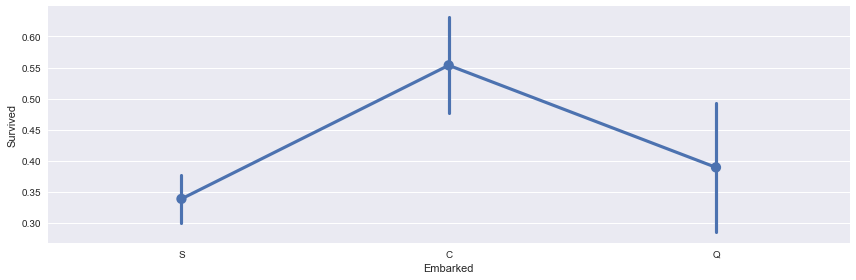

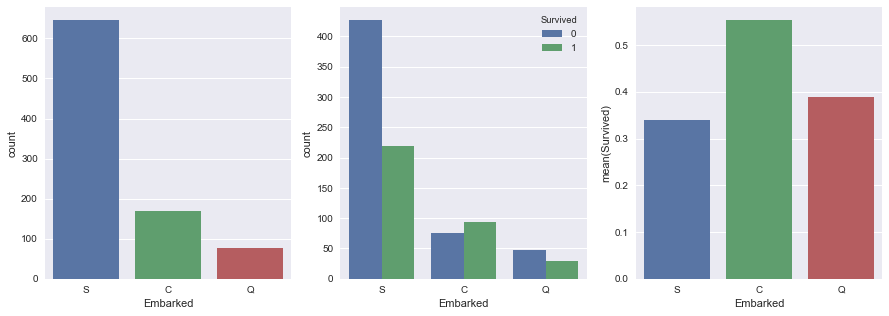

In [274]:
sns.factorplot('Embarked', 'Survived', data=train_df, size=4, aspect=3)

# 统计，绘图。通过countplot可以直接实现
# embarked_df = train_df.groupby(['Embarked', 'Survived']).size().reset_index(name='Count')
# sns.barplot(x='Embarked', y='Count', hue='Survived', data=embarked_df, ax=ax2, order=['S', 'C', 'Q'])

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.countplot(x='Embarked',  data=train_df, ax=ax1)
sns.countplot(x='Embarked', hue='Survived', data=train_df, ax=ax2)

embarked_per = train_df[['Embarked', 'Survived']].groupby('Embarked', as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', data=embarked_per, order=['S', 'C', 'Q'], ax=ax3)

plt.show()

对特征Embarked进行处理

In [275]:
embark_dummies = pd.get_dummies(train_df['Embarked'])
embark_dummies.drop('S', axis=1, inplace=True)

train_df = train_df.join(embark_dummies)
train_df.drop(['Embarked'], axis=1, inplace=True)
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,C,Q
0,0,3,male,22.0,1,0,7.2500,NaN,0,0
1,1,1,female,38.0,1,0,71.2833,C85,1,0
2,1,3,female,26.0,0,0,7.9250,NaN,0,0
3,1,1,female,35.0,1,0,53.1000,C123,0,0
4,0,3,male,35.0,0,0,8.0500,NaN,0,0


## Fare

票价。可以看出测试集中没有NaN

In [276]:
train_df.isnull()['Fare'].value_counts()

False    891
Name: Fare, dtype: int64

看一下Fare的分布，可以发现低价票很集中

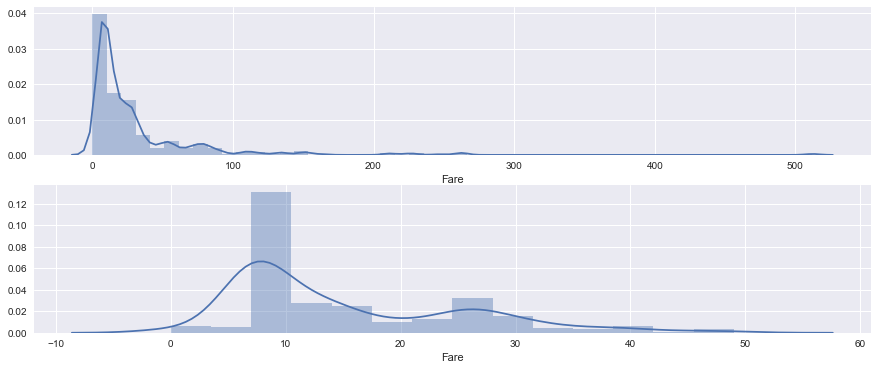

In [277]:
train_df['Fare'] = train_df['Fare'].astype(int)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 6))
sns.distplot(train_df.loc[:, 'Fare'], ax=ax1)
sns.distplot(train_df.loc[train_df['Fare']<50, 'Fare'], ax=ax2)
plt.show()

详细地，我们对票价分档

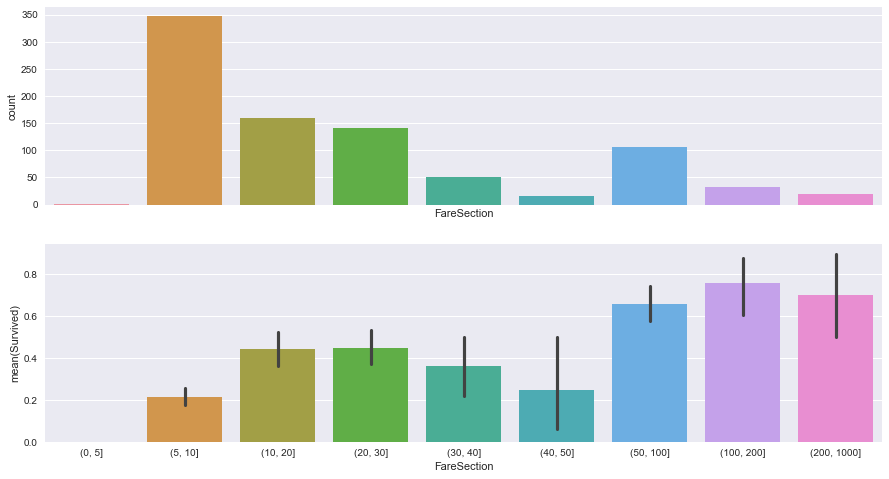

In [297]:
train_df['FareSection'] = pd.cut(train_df['Fare'], [0, 5, 10, 20, 30, 40, 50, 100, 200, 1000])

# 每档的数量
f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 8), sharex=True)
ax = sns.countplot("FareSection", data=train_df, ax=ax1)

# 每档的存活率
ax = sns.barplot(x="FareSection", y="Survived", data=train_df, ax=ax2)

In [166]:
print(train_df.loc[train_df['Survived'] == 0, 'Fare'].describe())
print()
print(train_df.loc[train_df['Survived'] == 1, 'Fare'].describe())

count    549.000000
mean      21.690346
std       31.392191
min        0.000000
25%        7.000000
50%       10.000000
75%       26.000000
max      263.000000
Name: Fare, dtype: float64

count    342.000000
mean      47.991228
std       66.608344
min        0.000000
25%       12.000000
50%       26.000000
75%       57.000000
max      512.000000
Name: Fare, dtype: float64


In [237]:
fare_section = train_df.groupby(pd.cut(train_df['Fare'], [0, 5, 10, 20, 30, 40, 50, 100, 200, 1000])).\
agg({'Survived': 'mean', 'Fare': 'mean', 'Age': 'size'})

fare_section.rename(index=str, columns={'Age': 'Count'}, inplace=True)
# del(fare_section.index.name)

display(fare_section)

,Survived,Fare,Count
Fare,,,
"(0, 5]",0.000000,4.500000,2
"(5, 10]",0.216138,7.556196,347
"(10, 20]",0.443750,14.518750,160
"(20, 30]",0.450704,25.915493,142
"(30, 40]",0.360000,34.800000,50
"(40, 50]",0.250000,45.937500,16
"(50, 100]",0.660377,69.094340,106
"(100, 200]",0.757576,130.575758,33
"(200, 1000]",0.700000,278.950000,20


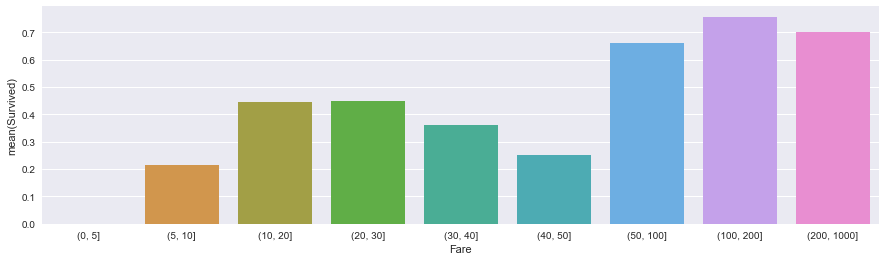

In [245]:
plt.figure(figsize=(15, 4))

sns.barplot(x=fare_section.index, y='Survived', data=fare_section)